# Parallel Process Monte Carlo Simulations with Python

The <a href="https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo" target="_blank">Markov Chain Monte Carlo (MCMC)</a> method is a widely used method involving repeated sampling of random numbers to simulate a physical system. Due to the large numbers of iterations involved, Monte Carlo algorithms usually take a long time to finish running. In this post, we will explore how running the MCMC algorithm using parallel processes can help speed the computation time up. 

In particular, we will be looking at how to implement the <a href="https://en.wikipedia.org/wiki/Metropolis–Hastings_algorithm" target = "_blank">Metropolis algorithm</a> to numerically generate a solution to the 2D Ising model. We assume that the reader is already familiar with the 2D Ising model, and we will be focussed on implementing the algorithm using parallel processing rather than the implementation of the algorithm itself. 

## Parallel Processing in Python

We will be using `Process`, `JoinableQueue` and `Queue` from the `multiprocessing` module to implement the parallel processing functionality. In the code we will use a `main` function to execute the entire simulation, and a `Worker` class to implement the parallel processing. We will first look at the `main` function before looking at the `Worker` class.

The `main` function is composed as shown in the code below. It has several input arguments: `D` is the number of physical dimensions, `J` the split coupling parameter, `H` is the external magnetic field, `T` is the list of temperatures to iterate through, `Nx` is the number of spins per dimension (we assume a cubic system), `steps` is the number of iterations to take and `nprocs` is the number of parallel processors to use. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import random
import time
random.seed() #seed the RNG.
import multiprocessing as mp

import warnings 
warnings.filterwarnings("ignore")

def main(D = 2, J = 1, H = 0, T = np.linspace(0.01,5,50), Nx = 20, steps = 100000, nprocs = 2):
    """
    Main driver function for the parallel process MC
    
    Inputs
    ------
    D: int
        number of spatial dimensions
    J: int
        coupling strength
    H: float
        external magnetic field strength
    T: np.array
        np.array of temperatures to conduct the MC simulation over
    Nx: int
        number of spins on each side of the cubic crystal
    steps: int
        number of MC steps to take
    nprocs: int
        number of parallel processors to use
        
    Returns
    -------
    T2: np.array
        temperatures
    M2: np.array
        magnetization
    """
    starttime = time.time()
    
    # Use a JoinableQueue to hold the individual temperature values to be iterated in parallel.
    q = mp.JoinableQueue()
    for t in T:
        q.put(t)
        
    # Use a Queue to hold the simulation output.
    results = mp.Queue()
    
    # Instantiate individual parallel processes using Process.
    processes = []
    for i in range(nprocs):
        worker = mp.Process(target = Worker(D, J, H, Nx, steps, steps, results), args = (q,), daemon = True)
        # Don't forget to start the process!
        worker.start()
        processes.append(worker)
        
    # Join the JoinableQueue q (containing input args) to the started parallel processes.
    q.join()
    
    T2 = []
    M2 = []
    # This for loop iterates through all temperatures in parallel.
    for i in range(len(T)):
        # Get the simulation results, and store them in T2 and M2.
        t, m = results.get()
        T2.append(t)
        M2.append(m)
        
    T2 = np.array(T2)
    M2 = np.array(M2)    
    # Sort the results in the order of increasing temperature.
    sorted_indices = np.argsort(T2)
    T2 = T2[sorted_indices]
    M2 = M2[sorted_indices]
    print("Total time elapsed: {:.3f}s".format(time.time()-starttime))
    
    return T2, M2

We use a `JoinableQueue` `q` to hold the individual temperature values to be iterated through with the parallel process, and a `Queue` `results` to contain the outputs from the parallel processes.

We then iterate through `nprocs`, the number of parallel processes to be used, and instantiate individual parallel processes using `Process` from the `multiprocessing` module. `Process` requires a target function to instantiate the parallel process and arguments `args` to iterate through. We also set each process to be a daemonic process to prevent each process from creating its own child processes. In our example, the target function is the `Worker` class and the `args` to iterate through is a tuple of `JoinableQueue` `q` of temperatures. Note that the `Queue` results used to contain the parallel process output is an argument of the `Worker` class.

After executing the simulation in parallel, we need to extract the output results from the `Queue` `results`. As `Queues` cannot be directly iterated using a for loop, we perform the iteration using the number of input temperatures. The output is a tuple containing a temperature-magnetism pair. As we cannot control the order of the parallel process, the output temperature does not necessarily follow the original temperature list order. We then sort both output temperatures and magnetism in order of increasing temperature, and return the final simulation results. This ends our discussion on the `main` driver function.

We next explore the `Worker` class used to instantiate the parallel process. The `Worker` class is initialized using the Monte Carlo algorithm parameters, as well as the `Queue` results used to hold the parallel process outputs.

In [2]:
class Worker:
    def __init__(self, D, J, H, Nx, steps, warmup_steps, results):
        self.D = D # number of spatial dimensions. D = 2 or 3 only.
        self.J = J # coupling strength J
        self.H = H # external magnetic field H
        self.Nx = Nx # number of spins per dimension. We assume a cubic lattice
        self.steps = steps # number of MC steps
        self.warmup_steps = warmup_steps # number of MC warmup steps     
        self.N = Nx ** D # total number of spins in cubic lattice
        self.k = 1 # Boltzmann constant kB
        self.results = results # results queue
        
    def __call__(self, q):
        """
        Inputs
        ------
        q: mp.JoinableQueue
            JoinableQueue of temperatures
        """
        while True:
            # Get the input args from the JoinableQueue q.
            t = q.get()
            if t is None:
                return
            
            #print("Processing temperature: {}".format(t))
            m = 0
            spin = np.ones(self.N)
            B = 1.0 / (self.k * t)
            
            pflip = self.calc_pflip(B) 
                
            for n in range(self.warmup_steps):
                spin = self.isingmodel(spin, pflip)
            for n in range(self.steps):
                spin = self.isingmodel(spin, pflip)
                m = m + np.sum(spin) / self.N
            m = np.abs(m / self.steps)
            
            # Output the parallel processed results to the Queue results.
            self.results.put([t, m])
            
            # Don't forget to inform the JoinableQueue q that the current task is done!
            q.task_done()
            
    def calc_pflip(self, B):
        """
        Calculates the probability of spin flip
        Inputs
        ------
        B: float
            1/kT
        Returns
        -------
        pflip: float
            probability of spin flip
        """
        if self.D == 2:
            pflip = np.zeros([2, 5])
            Si = 1
            Sj = -4
            for i in range(2):  
                for j in range(5):  
                    pflip[i, j] = np.exp(2 * (self.H + self.J * Sj) * Si * -B)  
                    Sj = Sj + 2  
                Si = -1  
                Sj = -4  
        elif self.D == 3:
            pflip = np.zeros([2, 7])
            Si = 1
            Sj = -6
            for i in range(2):
                for j in range(7):
                    pflip[i, j] = np.exp(2 * (self.H + self.J * Sj) * Si * -B)
                    Sj = Sj + 2  
                Si = -1  # "reset" Si
                Sj = -6  # reset Sj
        return pflip
    
    def isingmodel(self, spin, pflip):
        """
        Wrapper function for the actual 2D or 3D Ising model.
        Inputs
        ------
        spin: np.array
            np.array of spins
        pflip: float
            Probability of spin flip
        """
        if self.D == 2:
            spin = self.ising2D(spin, pflip)
        elif self.D == 3:
            spin = self.ising3D(spin, pflip)
        return spin
    
    def ising2D(self, spin, pflip):
        """
        Inputs
        ------
        spin: np.array
            np.array of spins
        pflip: float
            Probability of spin flip
        """      
        N = self.Nx ** self.D
        Nx = self.Nx
        Ny = self.Nx
        r = int(random.random() * N)
        x = np.mod(r, Nx)
        y = r // Nx
        s0 = spin[r]
        s1 = spin[np.mod(x + 1, Nx) + y * Ny]
        s2 = spin[x + np.mod(y + 1, Ny) * Nx]
        s3 = spin[np.mod(x - 1 + Nx, Nx) + y * Nx]
        s4 = spin[x + np.mod(y - 1 + Ny, Ny) * Nx]
        neighbours = s1 + s2 + s3 + s4
        if s0 == 1:
            pfliprow = 0
        elif s0 == -1:
            pfliprow = 1
        if neighbours == -4:
            pflipcol = 0
        elif neighbours == -2:
            pflipcol = 1
        elif neighbours == 0:
            pflipcol = 2
        elif neighbours == 2:
            pflipcol = 3 
        elif neighbours == 4:
            pflipcol = 4
        rand = random.random()
        if rand < pflip[pfliprow, pflipcol]:
            spin[r] = -spin[r] 
        return spin
    
    def ising3D(self, spin, pflip):
        """
        Inputs
        ------
        spin: np.array
            np.array of spins
        pflip: float
            Probability of spin flip
        """
        N = self.N
        Nx = self.Nx
        Ny = self.Nx
        Nz = self.Nx
        r = int(random.random() * N)
        x = np.mod(r, Nx)
        y = np.mod(r // Nx, Ny)
        z = r // Nx // Ny
        s0 = spin[r]
        s1 = spin[np.mod(x + 1, Nx) + y * Ny + z * Ny * Nz]
        s2 = spin[x + np.mod(y + 1, Ny) * Nx + z * Ny * Nz]
        s3 = spin[np.mod(x - 1 + Nx, Nx) + y * Nx + z * Ny * Nz]
        s4 = spin[x + np.mod(y - 1 + Ny, Ny) * Nx + z * Ny * Nz]
        s5 = spin[x + y * Ny + np.mod(z - 1, Nz) * Ny * Nz]
        s6 = spin[x + y * Ny + np.mod(z + 1, Nz) * Ny * Nz]
        neighbours = s1 + s2 + s3 + s4 + s5 + s6
        if s0 == 1:
            pfliprow = 0
        elif s0 == -1:
            pfliprow = 1
        if neighbours == -6:
            pflipcol = 0
        elif neighbours == -4:
            pflipcol = 1
        elif neighbours == -2:
            pflipcol = 2
        elif neighbours == 0:
            pflipcol = 3 
        elif neighbours == 2:
            pflipcol = 4
        elif neighbours == 4:
            pflipcol = 5
        elif neighbours == 6:
            pflipcol = 6
        rand = random.random()
        if rand < pflip[pfliprow, pflipcol]:
            spin[r] = -spin[r] 
        return spin 

For convenience sake, we use the `__call__` function to allow us to call the `Worker` class as a function directly. Within `__call__`, we obtain the temperature to process from the `JoinableQueue` `q` using `t = q.get()`.  If there are no more temperatures to process, `None` is returned and the process ends. The physical simulation is then performed, and the output is stored in the `Queue` `results` using `self.results.put([t, m])`. At the very end, `q.task_done()` is used to signal to the `JoinableQueue` that a particular temperature has been successfully processed from the `JoinableQueue`. This step is compulsory in order for the parallel process to be executed successfully!

Finally, we explore the code implementing the physical simulation. `calc_pflip` pre-calculates the probabilities of a spin flipping. The pre-calculation is done before the Monte Carlo steps in order to speed up processing time.

The physical system is represented in the `isingmodel`, `ising2D` and `ising3D` functions. In the current code, we are able to simulate both 2D and 3D crystals. This function iterates through the Monte Carlo algorithm, and calculates the crystal's magnetism for a particular temperature.

This ends our exploration into the `Worker` class which implements the Monte Carlo simulation as a parallel process in Python! The full code is given right at the bottom of this post. In order to run the Monte Carlo simulation, all we need to do is to call the main function as follows, and plot the results.

For the 2D crystal simulation above, we get the following plot of temperature vs. magnetism, which clearly shows the ferromagnetic phase transition as temperature decreases below `T = 2`.

Total time elapsed: 323.052s


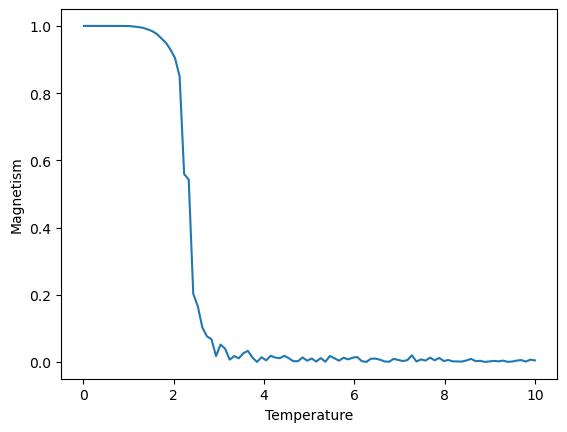

In [3]:
T, M = main(D = 2, J = 1, H = 0, T = np.linspace(0.01, 10, 100), Nx = 20, steps = 100000, nprocs = 4)
plt.plot(T, M)
plt.xlabel("Temperature")
plt.ylabel("Magnetism")
plt.show()

This ends our exploration into implementing a parallel process Monte Carlo simulation using Python. 

## Github Repository

More computational physics codes can be found in my <a href="https://github.com/natsunoyuki/Computational_Physics_in_Python" target="_blank">Github repository</a>.

## References
* https://docs.python.org/2/library/multiprocessing.html
* https://pymotw.com/2/multiprocessing/communication.html
* http://www1.spms.ntu.edu.sg/~ydchong/teaching/PH4505-12.htm